In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import add
from keras.utils import plot_model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# ResNet

## Create residual_module


![alt text](https://i.ibb.co/ZJbM5NF/residual-module.png)

In [ ]:
def residual_module(layer_in, n_filters):
  # These two are F(x)
  conv1 = Conv2d(n_filters, (3,3), padding = 'same', activation = 'relu')(layer_in)
  conv2 = Conv2d(n_filters, (3,3), padding = 'same', activation = 'linear')(conv1)

  # x and f(x) must have the same shape
  layer_out = add([conv2, layer_in])
  layer_out = Activation('relu')(layer_out)

  return layer_out

### There is a Problme :/ !

A limitation with this direct implementation is that if the number of filters in the input layer does not match the number of filters in the last convolutional layer of the module (defined by n_filters), then we will get an error.

### Projection shortcut

The projection shortcut  is used to match dimensions (done by 1×1 convolutions).
Changes shape of the output of a layer

In [ ]:
def residual_module(layer_in, n_filters):
  merge_input = layer_in
  # Check x and f(x) shape
  if layer_in.shape[-1] != n_filters:
    merge_input = Conv2D(n_filters, (1,1), padding='same',activation='relu')(layer_in)
  # These two are F(x)
  conv1 = Conv2D(n_filters, (3,3), padding = 'same', activation = 'relu')(layer_in)
  conv2 = Conv2D(n_filters, (3,3), padding = 'same', activation = 'linear')(conv1)

  # x and f(x) must have the same shape
  layer_out = add([conv2, merge_input])
  layer_out = Activation('relu')(layer_out)

  return layer_out

## Model

In [ ]:
X = Input(shape=(64, 64, 3))

# 1
output = residual_module(X, 64)
output = MaxPooling2D(pool_size = 2)(output)

# 2
output = residual_module(output, 128)
output = MaxPooling2D(pool_size = 2)(output)

# 3
output = residual_module(output, 256)
output = MaxPooling2D(pool_size = 2)(output)

# 4 
output = residual_module(output, 512)
output = MaxPooling2D(pool_size = 2)(output)

# conv-flatten
# Downsample
output = Conv2D(64, (1,1), activation='relu')(output)
output = Flatten()(output)

# Dense layer to do the classification
output = Dense(512, activation='relu')(output)
output = Dense(10, activation='softmax')(output)


# create model
model = Model(inputs=X, outputs = output)

In [ ]:
# plot model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 64)   256         input_3[0][0]                    
______________________________________________________________________________________________

## Load data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/datasets/EuroSAT.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
import os
DIR = '/tmp/2750/'
class_names = os.listdir(DIR)
class_names

['River',
 'PermanentCrop',
 'Pasture',
 'SeaLake',
 'Highway',
 'HerbaceousVegetation',
 'Forest',
 'AnnualCrop',
 'Residential',
 'Industrial']

### ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale= 1./255, validation_split = 0.2)

#### read data from directory 

In [ ]:
training_set = train_datagen.flow_from_directory(
    DIR,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

Found 21600 images belonging to 10 classes.


In [ ]:
validation_set = train_datagen.flow_from_directory(
    DIR,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

Found 5400 images belonging to 10 classes.


### plot data

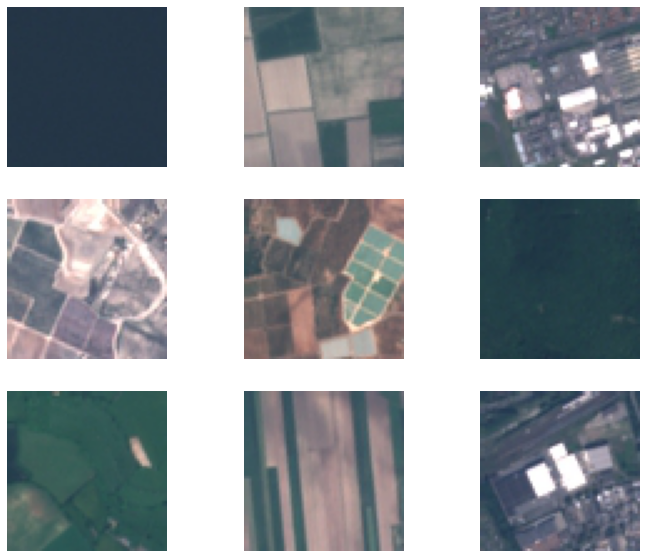

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = training_set[0][0][i]
    plt.imshow(img)
    plt.axis('off')
    
# show the plot
plt.show()

### compile and fit model

In [ ]:
# compile
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# step = samples / #of batches
# increase batch size to test faster with less complexity
history = model.fit(
    training_set,
    epochs = 200,
    validation_data = validation_set,
    validation_steps = validation_set.samples // 32,
    steps_per_epoch = training_set.samples // 32
)

Epoch 1/200
609/675 [==========================>...] - ETA: 2s - loss: 1.6513 - accuracy: 0.3447

KeyboardInterrupt: ignored

In [ ]:
# PRETRAIN MODELS
# weights trained on imagenet
resnet_model = keras.applications.resnet.ResNet50(weights='imagenet',
                                                  include_top=False,
                                                  input_shape=(64,64,3))
# For transfer learning indlue_top should be false so we can use it on our data
# input_shape only when include_top is false

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:

for index, layer in enumerate(resnet_model.layers):
  print(index, layer.name, layer.trainable)

0 input_4 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [ ]:
model = keras.models.Sequential()

model.add(resnet_model)

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(10, activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 31,987,594
Trainable params: 31,934,474
Non-trainable params: 53,120
_________________________________________________________________


Pretrained weights should be locked to prevent changing in first epochs.

Because last layers are not trained yet and have random weights and backprops
big error

In [ ]:
# Freeze layers[0] pretrained resnet trainable
for layers in model.layers[0].layers:
  layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(lr = 0.2, momentum=0.9)

In [ ]:
# compile
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# step = samples / #of batches
# increase batch size to test faster with less complexity
history = model.fit(
    training_set,
    epochs = 20,
    validation_data = validation_set,
    validation_steps = validation_set.samples // 32,
    steps_per_epoch = training_set.samples // 32
)

Epoch 1/20
148/675 [=====>........................] - ETA: 33s - loss: 9292388719810055241728.0000 - accuracy: 0.1104

KeyboardInterrupt: ignored

Can then unfreeze with the new last layer weights and do some epochs with unfreeze mode

In [ ]:
# Freeze layers[0] pretrained resnet trainable
for layers in model.layers[0].layers:
  layer.trainable = True

In [ ]:
# compile
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# step = samples / #of batches
# increase batch size to test faster with less complexity
history = model.fit(
    training_set,
    epochs = 50,
    validation_data = validation_set,
    validation_steps = validation_set.samples // 32,
    steps_per_epoch = training_set.samples // 32
)

Epoch 1/50


KeyboardInterrupt: ignored